In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
import scipy

from evo.core import metrics

from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint


from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

import seaborn as sns

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

[DEBUG][2020-02-03 13:18:47,622][log.configure_logging():115]
System info:
Python 2.7.15+
Linux-4.15.0-74-generic-x86_64-with-Ubuntu-18.04-bionic
anne@ThinkPad-P50



Load two trajectory files in TUM format

In [30]:
from evo.tools import file_interface
from evo.core import sync
from evo.core import trajectory
root = "scale/"


room1 = root+"fr3_long"
room2 = root+"fr2_desk"
room3 = root+"fr3_struct_text_far"
room4 = root+"fr3_nostruct_text_near"
room = room3
# kinect_error = 1./1.035


sparse_points = np.load(room+'/sparse_points.npy')
est_points = np.load(room+'/est_points.npy')
targ_points = np.load(room+'/targ_points.npy')
n_points = np.load(room+'/n_depths.npy')
indexes = np.load(room+'/indexes.npy')
indexes = indexes.reshape(len(indexes)/2,2)

if room == room1:
    ref_file = room1+"/rgbd_dataset_freiburg3_long_office_household-groundtruth.txt"
    room_scale = 2.43126284678
elif room == room2:
    ref_file = room2+"/rgbd_dataset_freiburg2_desk-groundtruth.txt"
    room_scale = 2.1582600441
    targ_points = targ_points*1.031
elif room == room3:
    ref_file = room3+"/rgbd_dataset_freiburg3_structure_texture_far-groundtruth.txt"
    room_scale = 1.89191437662
elif room == room4:
    ref_file = room4+"/rgbd_dataset_freiburg3_nostructure_texture_near_withloop-groundtruth.txt"
    room_scale = 1.2938425785
else:
    raise("Unknown room")


est_file = room+"/KeyFrameTrajectory.txt"

traj_ref = file_interface.read_tum_trajectory_file(ref_file)
traj_est = file_interface.read_tum_trajectory_file(est_file)

[DEBUG][2020-02-03 16:14:26,321][file_interface.read_tum_trajectory_file():112]
Loaded 3156 stamps and poses from: scale/fr3_struct_text_far/rgbd_dataset_freiburg3_structure_texture_far-groundtruth.txt
[DEBUG][2020-02-03 16:14:26,325][file_interface.read_tum_trajectory_file():112]
Loaded 24 stamps and poses from: scale/fr3_struct_text_far/KeyFrameTrajectory.txt


In [14]:
from scipy import spatial

def cam_to_xyz(depths, indexes):
    # kinect params
    ratio = 0.475
    fx, fy = 525., 525.
    cx, cy = 319.5, 239.5
    
    fx *= ratio
    fy *= ratio
    cx *= ratio
    cy *= ratio
    
    u = indexes[:,1] # x is columns
    v = indexes[:,0] # y is rows
    
    x = (u - cx) * depths / fx
    y = (v - cy) * depths /fy 
    z = depths
    return zip(x.ravel(), y.ravel(), z.ravel())

def statistical_outlier_removal(data, k=20, std_mul=0.2):
    tree = spatial.cKDTree(data)
    distances, matches = tree.query(data, k)
    # remove self from matches
    distances = distances[:,1::]
    matches = matches[:,1::]

    _mean = np.mean(distances)
    _std = np.std(distances)

    mean_pp = np.mean(distances, axis=1)
    threshold = _mean + std_mul * _std
    rem_mask = mean_pp>threshold
    return rem_mask

def filter_mask(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    #     return data[s<m]
    return s>m   


gt scale: 1.892
estimate mean: 1.483
kinect mean: 1.753
walking end: 1.566
over 62 frames
frame10: 6
average samples 354.1


<IPython.core.display.Javascript object>


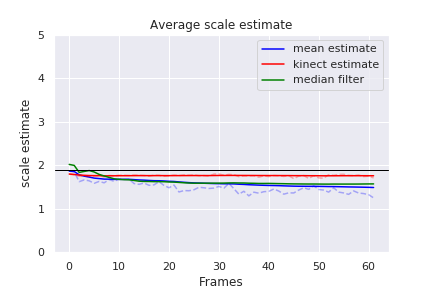

In [32]:
def _scale_error(scale, sparse, test):
    max_dist = 3.

    scales = test/sparse
    rem_mask = test>max_dist
    
#     se = np.abs(scale*sparse[~rem_mask] - test[~rem_mask])**2
    se = np.abs(scale*sparse - test)**2
    return se.sum()

n_prev = 0
est_scales = []
est_means = []

targ_scales = []
targ_means = []

mean_dist_spar = []
mean_dist_est = []
mean_dist_spar_filter = []
mean_dist_est_filter = []
mean_dist_targ = []

walking_scales = []
walking_means = []
frame_10 = None
for kf_index, n in enumerate(n_points):
    if n == 0:
        continue
    
    i = np.arange(n_prev, n_prev+n)
    j = np.arange(n_prev+n)
    spar = sparse_points[i]
    est = est_points[i]
    targ = targ_points[i]
    
    mean_dist_spar.append(np.mean(spar))
    mean_dist_est.append(np.mean(est))
    mean_dist_targ.append(np.mean(targ))
    

#     data = cam_to_xyz(sparse_points[i], indexes[i,:])
#     mask = statistical_outlier_removal(data, k=5, std_mul=1.0)

#     est_scale = minimize_scalar(_scale_error, args=(spar[~mask], est[~mask]))
#     targ_scale = minimize_scalar(_scale_error, args=(spar[~mask], targ[~mask]))
    est_scale = minimize_scalar(_scale_error, args=(spar, est))
    targ_scale = minimize_scalar(_scale_error, args=(spar, targ))
        
    est_scales.append(est_scale.x)
    est_means.append(np.mean(est_scales))
    
    targ_scales.append(targ_scale.x)
    targ_means.append(np.mean(targ_scales))
    
    # using all points up to now
    _est = est_points[j]
    _spar = sparse_points[j]
    mask = filter_mask(_est/_spar, m=0.5)
    walking_scale = minimize_scalar(_scale_error, args=(_spar[~mask], _est[~mask]))
    walking_scales.append(walking_scale.x)
    walking_means.append(np.mean(walking_scales))
    
    mean_dist_spar_filter.append(np.mean(spar[~mask[n_prev::]]))
    mean_dist_est_filter.append(np.mean(est[~mask[n_prev::]]))
    
    if walking_scale.x <= room_scale * 1.03 and walking_scale.x >= room_scale*0.97:
        if frame_10 is None and kf_index>4:
            frame_10 = kf_index+1

    
    n_prev += n
    
print("gt scale: %.3f" % room_scale)
print("estimate mean: %.3f" % est_means[-1])
print("kinect mean: %.3f" % targ_means[-1])
print("walking end: %.3f" % walking_scales[-1])
print("over %d frames" % len(est_means))
print("frame10: %d" % frame_10)
print("average samples %.1f" % np.mean(n_points))


fig = plt.figure()
# plt.style.use('science')
plt.plot(np.arange(len(est_means)), est_means, 'b', label="mean estimate")
plt.plot(np.arange(len(targ_means)), targ_means, 'r', label="kinect estimate")
plt.plot(np.arange(len(est_scales)), est_scales, 'b--', alpha=0.3)
plt.plot(np.arange(len(targ_scales)), targ_scales, 'r--', alpha=0.3)
plt.plot(np.arange(len(walking_scales)), walking_scales, 'g', label="median filter")
# plt.plot(np.arange(len(walking_scales)), walking_scales, 'g--', alpha=0.3)

plt.title("Average scale estimate")
plt.xlabel("Frames")
plt.ylabel("scale estimate")
plt.ylim(0,5)
plt.axhline(linewidth=1, y=room_scale, color='k')
plt.legend()
plt.show()

nn_scale = walking_scales[-1]


## median filter

<IPython.core.display.Javascript object>


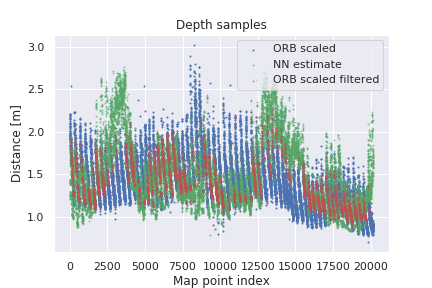

In [66]:
X = np.arange(len(mean_dist_spar))

# plt.figure()
# plt.plot(X, np.array(mean_dist_spar)*room_scale, label="orb")
# plt.plot(X, mean_dist_est, label="NN")
# plt.plot(X, mean_dist_targ, label="kinect")
# # plt.plot(X, mean_dist_targ, label="kinect")
# plt.legend()
# plt.show()

mask = filter_mask(est_points/sparse_points, m=0.5)

_est_points = np.copy(est_points)
_sparse_points = np.copy(sparse_points)
_est_points[mask] = np.nan
_sparse_points[mask] = np.nan

plt.figure()
plt.title("Depth samples")
plt.scatter(np.arange(len(est_points)), sparse_points*room_scale, s=1, label="ORB scaled")
plt.scatter(np.arange(len(est_points)), est_points, s=1, alpha=0.5, label="NN estimate")
plt.scatter(np.arange(len(est_points)), _sparse_points*room_scale, s=1, alpha=0.5, label="ORB scaled filtered")
plt.xlabel("Map point index")
plt.ylabel("Distance [m]")
plt.legend()
plt.show()


## ORB point errors

In [79]:
error = targ_points - sparse_points*room_scale

RMSE = np.sqrt(np.mean(error**2))
absrel = np.mean(np.abs(error/targ_points))
MAE = np.mean(np.abs(error))

print("RMSE: %.3f" % RMSE)
print("absrel: %.3f" % absrel)
print("MAE: %.3f" % MAE)
print("keyframes: %d" % len(n_points))
print("avg distance: %.3f" % np.mean(targ_points))
print("std distance: %.3f" % np.std(targ_points))
print("avg points: %d" % np.mean(n_points))
print("std point: %.3f" % np.std(n_points))

RMSE: 0.117
absrel: 0.067
MAE: 0.091
keyframes: 63
avg distance: 1.339
std distance: 0.259
avg points: 320
std point: 32.579


In [75]:
import copy
max_diff = 0.01

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)
traj_est_nn = copy.deepcopy(traj_est)
traj_est_nn.scale(nn_scale)
traj_est_aligned = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False, correct_only_scale=False)
traj_est_scaled =  trajectory.align_trajectory(traj_est, traj_ref, correct_scale=True, correct_only_scale=False)
traj_est_scaled_nn =  trajectory.align_trajectory(traj_est_nn, traj_ref, correct_scale=False, correct_only_scale=False)


[DEBUG][2020-01-27 19:14:47,877][sync.associate_trajectories():106]
Found 63 of max. 63 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).
[DEBUG][2020-01-27 19:14:47,880][trajectory.align_trajectory():394]
Aligning using Umeyama's method...
[DEBUG][2020-01-27 19:14:47,883][trajectory.align_trajectory():404]
Rotation of alignment:
[[-0.48651392 -0.77103817  0.41085807]
 [-0.87351188  0.42025542 -0.24568758]
 [ 0.01676917 -0.47841983 -0.87797111]]
Translation of alignment:
[-3.51885146  1.13756535  1.03561226]
[DEBUG][2020-01-27 19:14:47,884][trajectory.align_trajectory():405]
Scale correction: 1.0
[DEBUG][2020-01-27 19:14:47,893][trajectory.align_trajectory():394]
Aligning using Umeyama's method... (with scale correction)
[DEBUG][2020-01-27 19:14:47,896][trajectory.align_trajectory():404]
Rotation of alignment:
[[-0.48651392 -0.77103817  0.41085807]
 [-0.87351188  0.42025542 -0.24568758]
 [ 0.01676

<IPython.core.display.Javascript object>


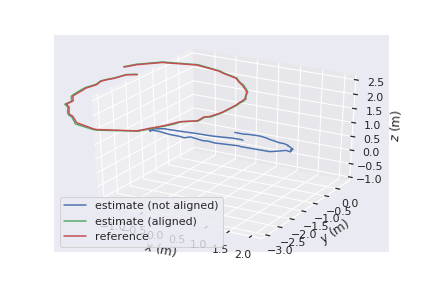

In [76]:
fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_est,
    "estimate (aligned)": traj_est_scaled_nn,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [81]:
pose_relation = metrics.PoseRelation.translation_part

data = (traj_ref, traj_est_aligned) 
# data = (traj_ref, traj_est_scaled)
# data = (traj_ref, traj_est_scaled_nn)
  
    
# APE
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

# get a single statistic
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)

# RPE
# normal mode
delta = 1

rpe_metric = metrics.RPE(metrics.PoseRelation.translation_part, delta, metrics.Unit.frames, all_pairs=True)
rpe_metric.process_data(data)
rpe_stat = rpe_metric.get_statistic(metrics.StatisticsType.rmse)

print("APE RMSE: %.4f" % ape_stat)
print("RPE RMSE: %.4f" % rpe_stat)

# ape_stats = ape_metric.get_all_statistics()
# pprint.pprint(ape_stats)

[DEBUG][2020-01-27 19:28:08,373][metrics.process_data():374]
Compared 63 absolute pose pairs.
[DEBUG][2020-01-27 19:28:08,376][metrics.process_data():376]
Calculating APE for translation part pose relation...
[DEBUG][2020-01-27 19:28:08,380][filters.id_pairs_from_delta():174]
Found 62 pairs with delta 1 (frames) among 63 poses using all pairs.
[DEBUG][2020-01-27 19:28:08,386][metrics.process_data():279]
Compared 62 relative pose pairs, delta = 1 (frames) with all pairs.
[DEBUG][2020-01-27 19:28:08,389][metrics.process_data():282]
Calculating RPE for translation part pose relation...
APE RMSE: 0.4532
RPE RMSE: 0.0651


In [44]:
# pose_relation = metrics.PoseRelation.rotation_angle_deg




[DEBUG][2020-01-27 18:28:31,052][filters.id_pairs_from_delta():174]
Found 180 pairs with delta 1 (frames) among 181 poses using all pairs.
[DEBUG][2020-01-27 18:28:31,059][metrics.process_data():279]
Compared 180 relative pose pairs, delta = 1 (frames) with all pairs.
[DEBUG][2020-01-27 18:28:31,062][metrics.process_data():282]
Calculating RPE for translation part pose relation...
RPE RMSE: 0.0078


<IPython.core.display.Javascript object>


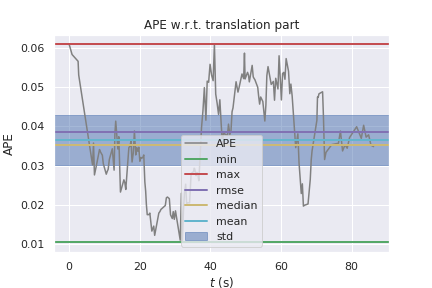

In [42]:
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
fig = plt.figure()
plot.error_array(fig, ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

<IPython.core.display.Javascript object>


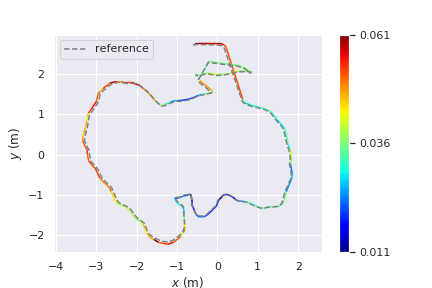

In [15]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_scaled_nn, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


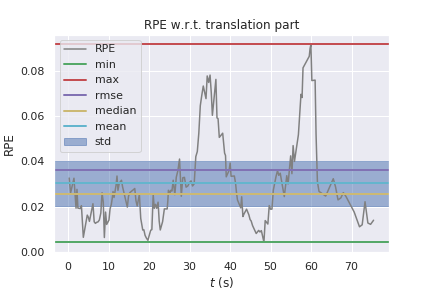

In [35]:
import copy
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
seconds_from_start = [t - traj_est.timestamps[14] for t in traj_est.timestamps[15:]]

# len(rpe_metric.error)
# len(seconds_from_start)

fig = plt.figure()
plot.error_array(fig, rpe_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in rpe_stats.items() if s != "sse"},
                 name="RPE", title="RPE w.r.t. " + rpe_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()



### Sparse scale estimation

In [20]:
%%time
data = cam_to_xyz(est_points, indexes)
rem_mask = statistical_outlier_removal(data)

CPU times: user 147 ms, sys: 3.38 ms, total: 150 ms
Wall time: 149 ms


In [123]:

def filter_mask(data):
    std_mul = .2
    
    mean = np.mean(data)
    stddev = np.std(data)
    
    threshold_max = mean + std_mul*stddev
    threshold_min = mean - std_mul*stddev
    
    return np.bitwise_or(data >= threshold_max, data <= threshold_min)
    
def filter_mask(data, m = 0.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    #     return data[s<m]
    return s>m   

<IPython.core.display.Javascript object>


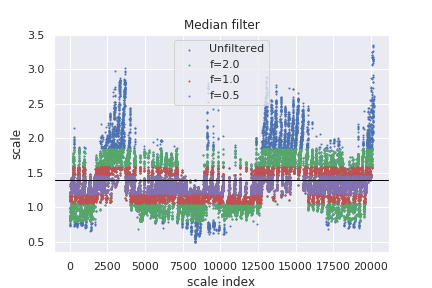

scale estimate mean: 1.318


In [78]:
from scipy.ndimage import gaussian_filter1d

n_total = np.sum(n_points)

est_errors = est_points - sparse_points
est_scales = est_points/sparse_points

targ_scales = targ_points/sparse_points

# fiter errors
error_gaus = gaussian_filter1d(est_errors,100)
scale_gaus = gaussian_filter1d(est_scales,100)

# filter the scales
scale_mask = filter_mask(est_scales, m=0.5)
f_est_scales = np.copy(est_scales)
f_est_scales[scale_mask] = np.nan

scale_mask = filter_mask(est_scales, m=1.)
f2_est_scales = np.copy(est_scales)
f2_est_scales[scale_mask] = np.nan

scale_mask = filter_mask(est_scales, m=2.)
f3_est_scales = np.copy(est_scales)
f3_est_scales[scale_mask] = np.nan

plt.figure()
plt.title("Median filter")
plt.xlabel("scale index")
plt.ylabel("scale")
plt.scatter(np.arange(len(est_scales)), est_scales, s=1, label="Unfiltered")
plt.scatter(np.arange(len(f_est_scales)), f3_est_scales, s=1, label="f=2.0")
plt.scatter(np.arange(len(f_est_scales)), f2_est_scales, s=1, label="f=1.0")
plt.scatter(np.arange(len(f_est_scales)), f_est_scales, s=1, label="f=0.5")
plt.legend()
plt.axhline(linewidth=1, y=np.mean(est_scales), color='k')
plt.show()

print("scale estimate mean: %.3f" % np.nanmean(f_est_scales))


# ORB points

<IPython.core.display.Javascript object>


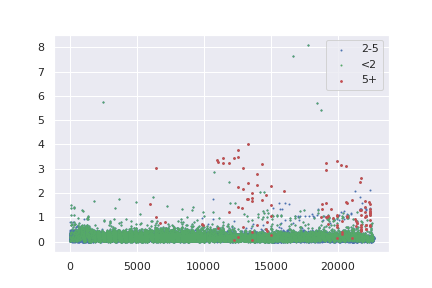

5+ mean error: 1.450, points: 113
2-5 mean error: 0.173, points: 22662
2 mean error: 0.200, points: 12899


In [83]:
sparse_points
targ_points

error = np.abs(targ_points - sparse_points*room_scale)

absrel = np.abs((targ_points-sparse_points*room_scale)/targ_points)


mean_distance = []
mean_error = []
n_prev = 0
for n in n_points:
    i = np.arange(n_prev, n_prev+n)
    if n == 0:
        continue
        
    _targ = targ_points[i]
    _sparse = sparse_points[i]*room_scale
        
    
    mean_distance.append(np.mean(_targ))
    mean_error.append(np.mean(np.abs(_targ-_sparse)))
    
    
    n_prev += n

X = np.arange(len(error))
error_5p = np.copy(error)
error_3 = np.copy(error)
error_2 = np.copy(error)
error_5p[targ_points<5] = np.nan
error_3[np.where(np.logical_and(targ_points<2, targ_points>=5))] = np.nan
error_2[targ_points<=2] = np.nan

plt.figure()
plt.scatter(X, error_3, s=1, label="2-5")
plt.scatter(X, error_2, s=1, label="<2")
plt.scatter(X, error_5p, s=3, label="5+")

plt.legend()
plt.show()

print("5+ mean error: %.3f, points: %d" % (np.nanmean(error_5p), np.count_nonzero(~np.isnan(error_5p))))
print("2-5 mean error: %.3f, points: %d" % (np.nanmean(error_3), np.count_nonzero(~np.isnan(error_3))))
print("2 mean error: %.3f, points: %d" % (np.nanmean(error_2), np.count_nonzero(~np.isnan(error_2))))

<IPython.core.display.Javascript object>


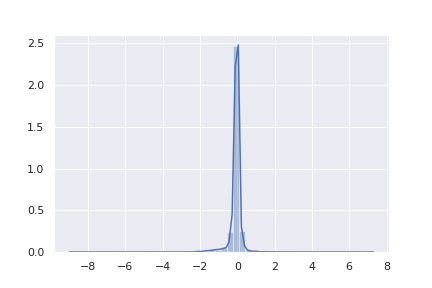

RMSE: 0.385
absrel: 0.085
MAE: 0.155
keyframes: 87
avg distance: 1.735
avg points: 219
std point: 63.244


In [148]:
# plt.figure()
# sns.distplot(targ_points - sparse_points*room_scale)
# plt.show()


error = targ_points - sparse_points*room_scale

RMSE = np.sqrt(np.mean(error**2))
absrel = np.mean(np.abs(error/targ_points))
MAE = np.mean(np.abs(error))

print("RMSE: %.3f" % RMSE)
print("absrel: %.3f" % absrel)
print("MAE: %.3f" % MAE)
print("keyframes: %d" % len(n_points))
print("avg distance: %.3f" % np.mean(targ_points))
print("avg points: %d" % np.mean(n_points))
print("std point: %.3f" % np.std(n_points))